In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle 
from neuron import h, gui
import networkx as nx

def Plot3D(ddir,name,inputsIdx=[],ax=None,scale=False):
    """
    3D plot of the neuron morphology highliting soma and inputs sections. 
    Warning: Needs h define as global object with cell morphology data already loaded in it.
    Params:
        - name: Filename to save the figure
        - inputsIdx: Index of sections receiving the inputs
    """
    
    Sections = [i for i in h.allsec()]

    Paths = [np.array(eval("h."+str(Sections[i])).psection()['morphology']['pts3d']) for i in range(len(Sections))]
    
    if ax==None:
        ax = plt.figure().add_subplot(projection='3d')
    
    SomaSec = [i for i in range(len(Sections)) if "soma" in str(Sections[i])]

    for i in SomaSec:
        
        if len(Paths[i])>0:
            ax.plot(Paths[i][:,0],Paths[i][:,2],Paths[i][:,1],'ro',ms=5,label="Soma",alpha=0.5)
        else:
            ax.plot(0.,0.,0.,'ro',ms=5,label="Soma",alpha=0.5)
            
    # Plot a sin curve using the x and y axes.
    for i in range(0,len(Paths)):

        if len(Paths[i])>0:
            xp = Paths[i][:,0]
            zp = Paths[i][:,1]
            yp = Paths[i][:,2]

            if i in inputsIdx:

                if i == inputsIdx[0]:
                    ax.plot(xp[-1],yp[-1],zp[-1],'^b',markersize=5,alpha=0.8,label="Inputs")
                else:
                    ax.plot(xp[-1],yp[-1],zp[-1],'^b',markersize=5,alpha=0.8)

            ax.plot(xp,yp,zp,'-k',linewidth=0.5)

    ps = []
    
    for j in [0,2,1]:

        pmin = np.min([np.min(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])
        pmax = np.max([np.max(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])

        ps.append([pmin,pmax])

    ax.set_aspect('equal')

    if scale==True:
        from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
        
        scalebar = AnchoredSizeBar(ax.transData, 2e-2, r"200 $\mu$m", 3,frameon=False,pad=5)

        ax.add_artist(scalebar)

    ax.set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
    ax.set_yticks(np.arange(100*(ps[1][0]//100),100*(ps[1][1]//100)+100,200))
    ax.set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));
    
    ax.set_xlabel(r"$\mu$m")
    ax.set_ylabel(r"$\mu$m")
    ax.set_zlabel(r"$\mu$m")
    
    ax.legend(markerscale=1,frameon=False)

    plt.savefig(ddir+"Neuron_"+name+"_inputs.png",dpi=500,bbox_inches="tight")

    return ax


In [2]:
def CreateAdjancyM(Labels):

    N = len(Labels)

    A = np.zeros([N,N],dtype=np.int32)

    for i in range(len(Labels)):

        dd = str(eval('h.'+Labels[i]).psection()['morphology']['trueparent']).split('(')[0]

        try:
            j = Labels.index(dd)

            A[i,j] = 1

        except:
            pass
        
    return A

def SectionInfo(G,A,Labels):
    """
    Give some morphology information about dendrite tree.
    """
    
    AvgDiam = []
    StdDiam = []
    DistPath = []
    Path = []
    Nbranch = []

    for k in range(len(Labels)):

        if 'soma' not in Labels[k]:

            Paths = [j for j in [i for i in nx.all_simple_paths(G, source=0, target=k)][0]]

            SecPaths = [Labels[j] for j in Paths]

            Path.append([Paths,SecPaths])

            DtoSom = [eval("h."+SecPaths[i]).psection()['morphology']['L'] for i in range(len(SecPaths))]

            DistPath.append(np.sum(DtoSom))
            
        else:
            Path.append([0,Labels[k]])
            DistPath.append(0.)
            
        AvgDiam.append(np.mean(eval("h."+Labels[k]).psection()['morphology']['diam']))
        StdDiam.append(np.std(eval("h."+Labels[k]).psection()['morphology']['diam']))
        Nbranch.append((np.sum(1*(A[:,k])==1)))
    
    #Minimum path length between soma and section
    DistPath = np.array(DistPath)
    
    #Average and standard deviation of section diameters
    AvgDiam = np.array(AvgDiam)
    StdDiam = np.array(StdDiam)
    
    #Number of section childrens
    Nbranch = np.array(Nbranch)
    
    #Measure euclidian distance between extremal point of a section and soma
    EucliDist = Euclid_dist(Labels)
    
    #Measure connection angle between parents and childrens
    Ldegree = Dist_conectin_angle(Labels,A)
    
    return DistPath,EucliDist,AvgDiam,StdDiam,Nbranch,Path,Ldegree

def Euclid_dist(Labels):
    """
    Measure euclidian distance between section and soma
    
    Params:
    - List of section labels
    
    Return:
        1D np.array of each section distance values
    """
    
    eucli = []
    
    soma = np.array([0.,0.,0.])

    for s in Labels:

        if "soma" not in s:

            ps = np.array(eval('h.'+s).psection()['morphology']['pts3d'][-1])[:3]

            eucli.append(ps)

        else:
            somap = np.array(eval('h.'+s).psection()['morphology']['pts3d'])
            
            if len(somap)>0:
                
                soma = 1*somap[-1][:3]
            
            eucli.append(soma)
    
    eucli = np.linalg.norm(np.array(eucli)-soma,axis=1)
    
    return eucli

def Dist_conectin_angle(Labels,A):
    """
    Compute the connection angle (in degrees) between the parent section and each child. 
    Soma and sections without children are ignored.
    
    Warning: Needs h define as global object with cell morphology data already loaded in it.
    
    Parameters:
     - Labels: List of sections labels
     - A: Adjacency matrix of dendritic tree topology.
     
    Return:
        - List of angles between the section and its children
        - List of section labels.
    """
    
    Ldegree = []
    
    for j in range(len(Labels)):
        
        if "soma" not in Labels[j]:

            Vec1 = np.diff(np.array(eval("h."+Labels[j]).psection()['morphology']['pts3d'])[-2:,:3],axis=0)

            if np.linalg.norm(Vec1)>0:

                Vec1 = Vec1[0]/np.linalg.norm(Vec1)

                idxChild = np.where(A[:,j]==1)[0]
                
                if len(idxChild)>0:

                    degree = []

                    for i in range(len(idxChild)):

                        Vec2 = np.diff(np.array(eval("h."+Labels[idxChild[i]]).psection()['morphology']['pts3d'])[:2,:3],axis=0)

                        if np.linalg.norm(Vec2)>0:

                            Vec2 = Vec2[0]/np.linalg.norm(Vec2)

                            degree.append(np.arccos(np.dot(Vec1,Vec2))*180/np.pi)

                        else:
                            break

                    Ldegree.append(degree)
                
                else:
                    Ldegree.append(np.nan)
            
            else:
                Ldegree.append(np.nan)

        else:
            Ldegree.append(np.nan)
           
    return Ldegree
    
def Morphoanalysis(ddir,filename,Celltype):
    
    Cellname = Celltype+files[i].split(".")[0]

    h.load_file(ddir+files[i])

    Labels = [str(i) for i in h.allsec() if "axon" not in str(i)]

    A = CreateAdjancyM(Labels)
    
    Extrems = 1*(np.sum(A,axis=0)==0)

    G = nx.from_numpy_array(A)

    DistPath,EucliDist,AvgDiam,StdDiam,Nbranch,Path,Ldegree = SectionInfo(G,A,Labels)

    Datos = pd.DataFrame()

    Datos["Cell_name"] = [Cellname]*len(DistPath)

    Datos["Labels"] = Labels

    Datos["Paths"] = Path

    Datos["PathLength"] = DistPath

    Datos["Section_eucli_dist"] = EucliDist

    Datos["AvgSecDiam"] = AvgDiam

    Datos["StdSecDiam"] = StdDiam

    Datos["Num_Branchs"] = Nbranch

    Datos["Connect_angle"] = Ldegree
    
    Datos["Extremes"] = Extrems
    
    Datos.to_csv(ddir+"Morpho_data_"+Cellname+".csv",index=False)

    Plot3D(ddir,Cellname)

    h('forall delete_section()')


In [3]:

celltype = "Pur_"

#ddir = "Pyramidal_cell_files/"
ddir = "Purkinje_cell_files/"

allfiles = os.listdir(ddir)

files = [i for i in allfiles if ('.hoc' in i)or('.nrn' in i)]


In [4]:
files

['Rapp_cell2.nrn',
 'P20.hoc',
 '19b972.nrn',
 'P19.hoc',
 'Rapp_cell1.nrn',
 'Rapp_cell3.nrn']

	1 
Purkinje cell morphology defined



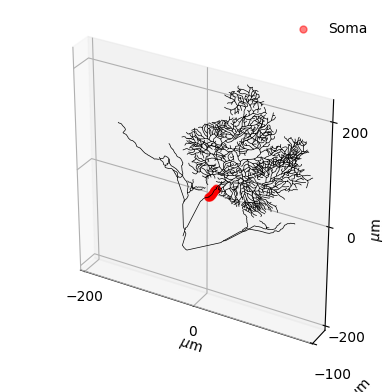

In [22]:
import pandas as pd

i = 2

Morphoanalysis(ddir,files[i],celltype)
    

# **BRANCHING PROBABILITY**

In [4]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

#ddir = "Pyramidal_cell_files/"
Ddir = ["Purkinje_cell_files/","Pyramidal_cell_files/"]

Pd = []

for ddir in Ddir:

    allfiles = os.listdir(ddir)

    files = [i for i in allfiles if ".csv" in i]

    pd1 = pd.read_csv(ddir+files[0])

    for i in range(1,len(files)):

        pd2 = pd.read_csv(ddir+files[i])

        pd1 = pd.concat([pd1,pd2])
    
    Pd.append(pd1)
    

1.0 9.954578956495006
1.0000000000000002 37.48554741897921


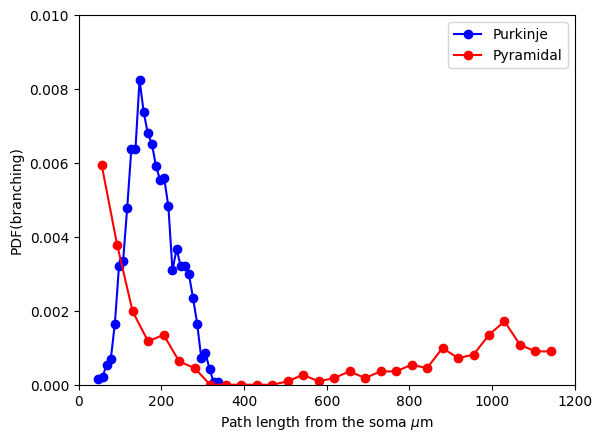

In [89]:
#Branching statistics

cl = ['b','r']
bb = [30,30]

Cell = ["Purkinje","Pyramidal"]

for i in range(len(Pd)):
    
    pd1 = Pd[i]
    
    Branch = pd1[(pd1.Num_Branchs > 1)]

    Branch = Branch.dropna()

    Plength = Branch.PathLength.values
    
    #bb = int((np.max(Plength)-np.min(Plength))/30)
    
    p,val = np.histogram(Plength,bins=bb[i],density=True)

    dx = np.mean(val[1:]-val[:-1])
    
    print(np.sum(p*dx),dx)
    
    #plt.bar(np.arange(val[0],val[-1],dx),p*dx,width=dx,alpha=0.5,edgecolor="b")
    plt.plot(0.5*(val[1:]+val[:-1]),p,"-o",color=cl[i],label=Cell[i])
    
    plt.ylabel("PDF(branching)")
    plt.xlabel(r"Path length from the soma $\mu$m")
    
    ProbList = []

    ProbList.append([0,val[0],0.])

    for j in range(len(val)-1):
        
        ProbList.append([np.round(val[j]),np.round(val[j+1]),p[j]*dx])

    ProbList = np.array(ProbList)

    #np.savetxt("Pyramidal_branch_prob.csv", ProbList, delimiter=",")
    np.savetxt(Cell[i]+"_branch_prob.csv", ProbList, delimiter=",")
    
plt.xlim(0,1200)
plt.ylim(0,0.01)

plt.legend()

plt.savefig("Branching_prob_prob_density.png",dpi=400,bbox_inches="tight")

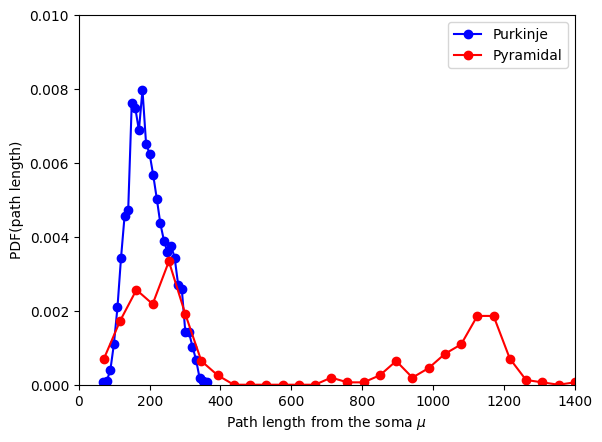

In [90]:

for i in range(len(Pd)):

    dist = Pd[i][Pd[i].Extremes == 1].PathLength.values

    p,val= np.histogram(dist,bins=30,density=True)

    dx = np.mean(val[1:]-val[:-1])
    vv = 0.5*(val[1:]+val[:-1])

    plt.plot(vv,p,'-o',color=cl[i],label=Cell[i])
    
    ProbList = []

    ProbList.append([0,val[0],0.])

    for j in range(len(val)-1):
        
        ProbList.append([np.round(val[j]),np.round(val[j+1]),p[j]*dx])

    ProbList = np.array(ProbList)

    #np.savetxt("Pyramidal_branch_prob.csv", ProbList, delimiter=",")
    np.savetxt(Cell[i]+"_pathlength_prob.csv", ProbList, delimiter=",")
    
plt.ylabel("PDF(path length)")
plt.xlabel(r"Path length from the soma $\mu$")

plt.ylim(0,0.01)
plt.xlim(0,1400)

plt.legend()

plt.savefig("Pathlength_prob_density.png",dpi=400,bbox_inches="tight")


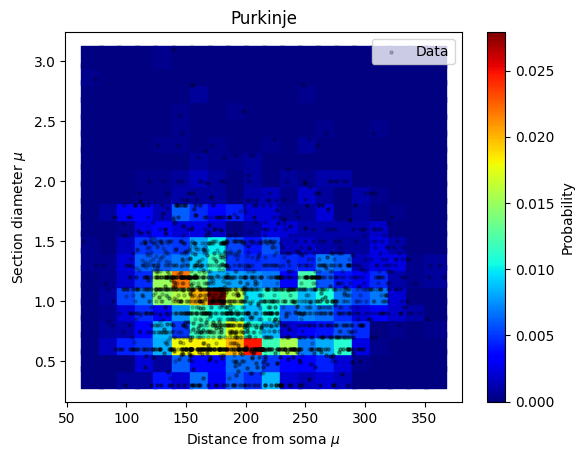

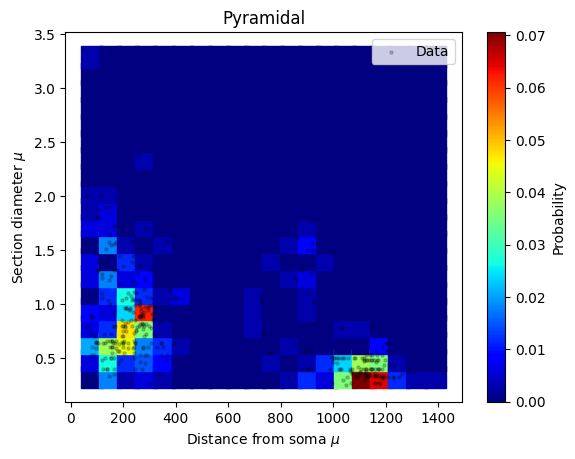

In [85]:
for i in range(2):
    
    fig = plt.figure()
    
    dist = Pd[i][Pd[i].Extremes == 1].PathLength.values

    diam = Pd[i][Pd[i].Extremes == 1].AvgSecDiam.values

    p,valx, valy = np.histogram2d(dist,diam,bins=20,density=True)

    dx = np.mean(valx[1:]-valx[:-1])
    dy = np.mean(valy[1:]-valy[:-1])

    xx,yy = np.meshgrid(0.5*(valx[1:]+valx[:-1]),0.5*(valy[1:]+valy[:-1]))

    cm = plt.scatter(xx.T,yy.T,c=p*dx*dy,cmap='jet',marker='s',s=250)

    plt.scatter(dist,diam,c='k',alpha=0.2,s=5,label="Data")

    plt.legend()

    plt.xlabel(r"Distance from soma $\mu$")

    plt.ylabel(r"Section diameter $\mu$")

    plt.colorbar(cm,label="Probability")

    plt.title(Cell[i])
    
    plt.savefig(Cell[i]+"_diameter_vs_distance.png",dpi=400,bbox_inches="tight")
    

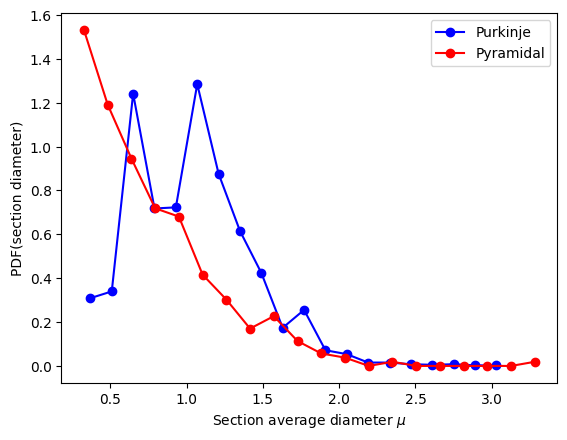

In [23]:

for i in range(len(Pd)):
    
    dist = Pd[i][Pd[i].Extremes == 1].PathLength.values

    diam = Pd[i][Pd[i].Extremes == 1].AvgSecDiam.values

    p,val= np.histogram2d(dist,diam,bins=20,density=True)

    dx = np.mean(val[1:]-val[:-1])
    vv = 0.5*(val[1:]+val[:-1])

    #plt.scatter(vv,p,'-o',color=cl[i],label=Cell[i])
    
    ProbList = []

    ProbList.append([0,val[0],0.])

    for j in range(len(val)-1):
        
        ProbList.append([np.round(val[j]),np.round(val[j+1]),p[j]*dx])

    ProbList = np.array(ProbList)

    #np.savetxt("Pyramidal_branch_prob.csv", ProbList, delimiter=",")
    #np.savetxt(Cell[i]+"_diameter_prob.csv", ProbList, delimiter=",")
    
plt.ylabel("PDF(section diameter)")
plt.xlabel(r"Section average diameter $\mu$")

plt.legend()

#plt.savefig("Diameter_prob_density.png",dpi=400,bbox_inches="tight")


# **ANALYSIS FROM CELL TEMPLATE**

In [5]:
ddir = "L5bPCmodelsEH/"

h.load_file("import3d.hoc")
h.load_file("nrngui.hoc")
h.load_file(ddir+"init.hoc")

morphology_file = ddir+"morphologies/cell1.asc"

h.load_file(ddir+"models/L5PCbiophys3.hoc")
h.load_file(ddir+"models/L5PCtemplate.hoc")

h.L5PCtemplate(morphology_file)


	0 
	1 


L5PCtemplate[0]

<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

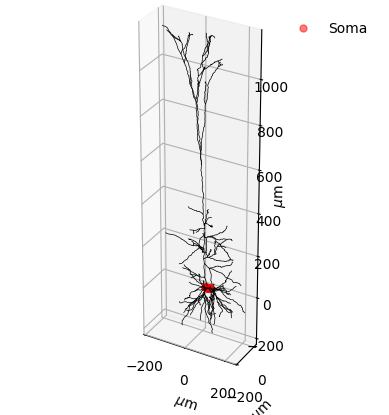

In [6]:
import pandas as pd

Cellname = "Pyr_p1_"

Labels = [str(i) for i in h.allsec() if "axon" not in str(i)]

A = CreateAdjancyM(Labels)

Extrems = 1*(np.sum(A,axis=0)==0)

G = nx.from_numpy_array(A)

DistPath,EucliDist,AvgDiam,StdDiam,Nbranch,Path,Ldegree = SectionInfo(G,A,Labels)

Datos = pd.DataFrame()

Datos["Cell_name"] = [Cellname]*len(DistPath)

Datos["Labels"] = Labels

Datos["Paths"] = Path

Datos["PathLength"] = DistPath

Datos["Section_eucli_dist"] = EucliDist

Datos["AvgSecDiam"] = AvgDiam

Datos["StdSecDiam"] = StdDiam

Datos["Num_Branchs"] = Nbranch

Datos["Connect_angle"] = Ldegree

Datos["Extremes"] = Extrems

Datos.to_csv("Morpho_data_"+Cellname+".csv",index=False)

Plot3D("",Cellname)


In [7]:
Branchidx = np.where(np.sum(A,axis=0) == 2)[0]

Extremsidx = np.where(np.sum(A,axis=0) == 0)[0]

Abranch = np.zeros([len(Branchidx)+1,len(Branchidx)+1],dtype=np.int8)


In [8]:

Level0 = []

for i in Extremsidx:
    
    Parent = np.where(A[i,:]==1)[0]
    
    if Parent in Branchidx:

        Level0.append(Parent[0])
    
Level0 = list(set(Level0))

nm = 0

while (len(Level0)>0):
    
    nm += len(Level0)
    
    Level1 = []
    
    for i0 in Level0:
        
        ss = 0
        
        Parent0 = np.where(A[i0,:]==1)[0]
        
        i = 1*i0
        
        ii = np.where(Branchidx==i0)[0]

        while (ss==0):
            
            Parent = np.where(A[i,:]==1)[0]
            
            if len(Parent) > 0:
                
                if Parent in Branchidx:

                    jj = np.where(Branchidx==Parent[0])[0]

                    Abranch[ii+1,jj+1] = 1
                    Abranch[jj+1,ii+1] = 1

                    if jj not in Level1 and jj != 0:

                        Level1.append(jj[0])

                    ss = 1

                elif Parent[0] == 0:
                    
                    Abranch[ii+1,0] = 1
                    Abranch[0,ii+1] = 1

                    ss = 1

                else:

                    i = 1*Parent
            else:
                
                ss=1
    
    Level0 = []
    
    Level0 = list(set(Level1))


In [9]:
Gbranch = nx.from_numpy_array(Abranch)


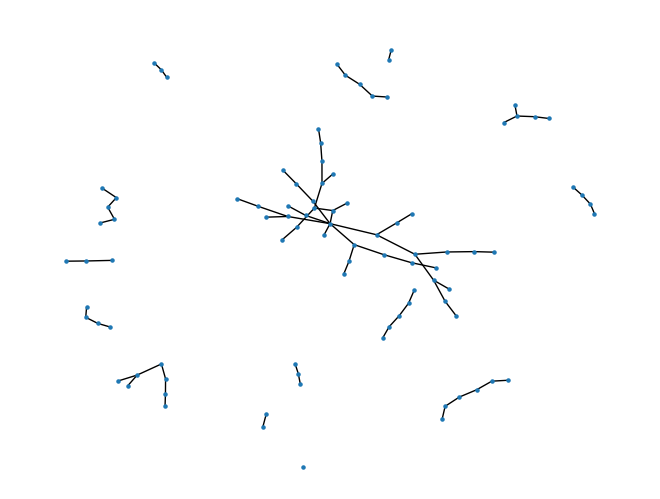

In [10]:
nx.draw(Gbranch,node_size=5)